In [1]:
# Install the correct version of prophet
!pip install prophet

# Import prophet
from prophet import Prophet


In [2]:
# Install the required packages
!pip install pandas matplotlib seaborn scikit-learn statsmodels prophet tensorflow

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet  # Updated from fbprophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

File Upload

In [4]:


from google.colab import files
import pandas as pd

uploaded = files.upload()

df = pd.read_csv('ett.csv')


# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Display the first few rows to confirm
df.head()



Saving ett.csv to ett (3).csv


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


Exploratory Data Analysis (EDA)

Missing values per column:
date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64


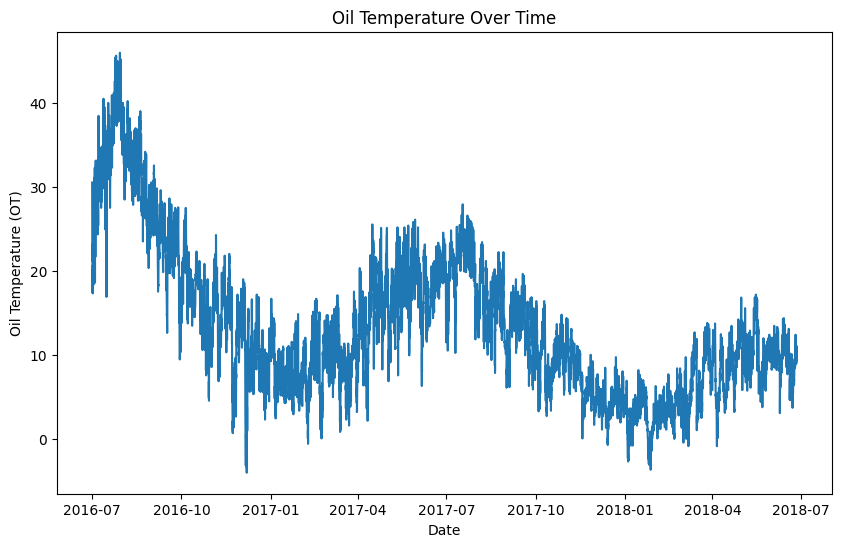

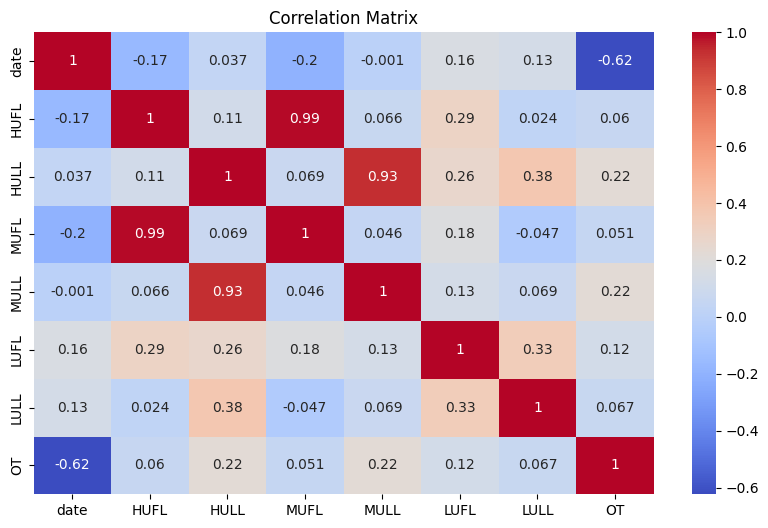

In [5]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Plot Oil Temperature over time
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['OT'])
plt.title('Oil Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Temperature (OT)')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Data Preprocessing

In [6]:
# Drop any rows with missing values (if necessary)
df = df.dropna()

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Set 'date' as the index for time series modeling
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

# Normalize the data for models that need it (e.g., LSTM)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(train[['OT']])
test_scaled = scaler.transform(test[['OT']])


LinearRegression Model

Linear Regression Model Evaluation Metrics:
Mean Squared Error (MSE): 0.43
Mean Absolute Error (MAE): 0.45
R-squared (R²): 0.9640
Root Mean Squared Error (RMSE): 0.65


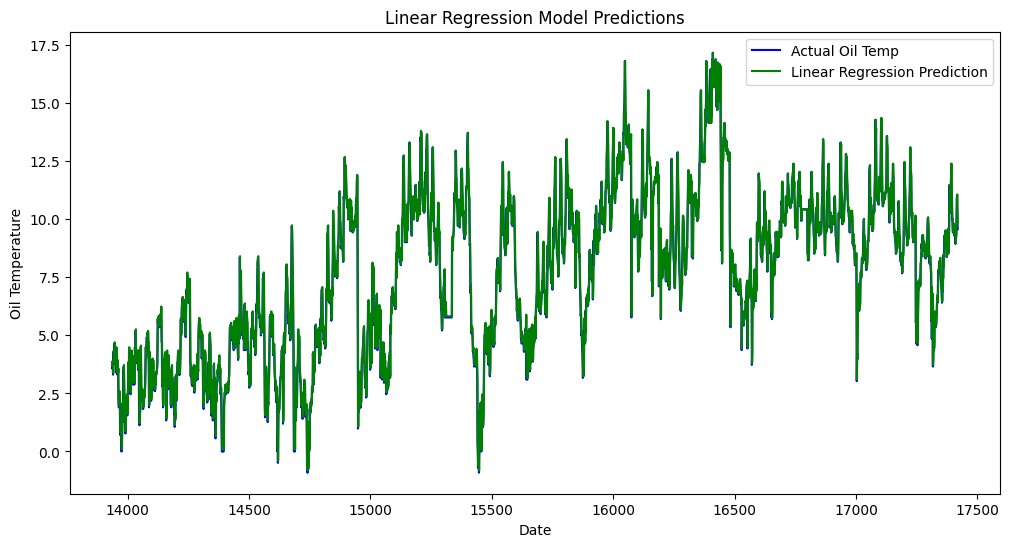

In [7]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Split into train and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Prepare the data for Linear Regression
X_lr = []
y_lr = []
for i in range(1, len(train)):
    X_lr.append(train['OT'].iloc[i-1])  # Previous value
    y_lr.append(train['OT'].iloc[i])    # Current value
X_lr = np.array(X_lr).reshape(-1, 1)
y_lr = np.array(y_lr)

# Train Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_lr, y_lr)

# Prepare the test data
X_test_lr = []
y_test_lr = []
for i in range(1, len(test)):
    X_test_lr.append(test['OT'].iloc[i-1])  # Previous value for test
    y_test_lr.append(test['OT'].iloc[i])    # Current value for test
X_test_lr = np.array(X_test_lr).reshape(-1, 1)
y_test_lr = np.array(y_test_lr)

# Make predictions
predicted_lr = model_lr.predict(X_test_lr)

# Evaluate Linear Regression model
mse_lr = mean_squared_error(y_test_lr, predicted_lr)
mae_lr = mean_absolute_error(y_test_lr, predicted_lr)
r2_lr = r2_score(y_test_lr, predicted_lr)
lr_rmse = np.sqrt(mse_lr)

# Print metrics
print(f"Linear Regression Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R-squared (R²): {r2_lr:.4f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.2f}")

# Plot Linear Regression predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[1:], y_test_lr, color='blue', label='Actual Oil Temp')
plt.plot(test.index[1:], predicted_lr, color='green', label='Linear Regression Prediction')
plt.title('Linear Regression Model Predictions')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()


ARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


ARIMA Model Evaluation Metrics:
Mean Squared Error (MSE): 25.80
Mean Absolute Error (MAE): 4.22
R-squared (R²): -1.1730
Root Mean Squared Error (RMSE): 5.08


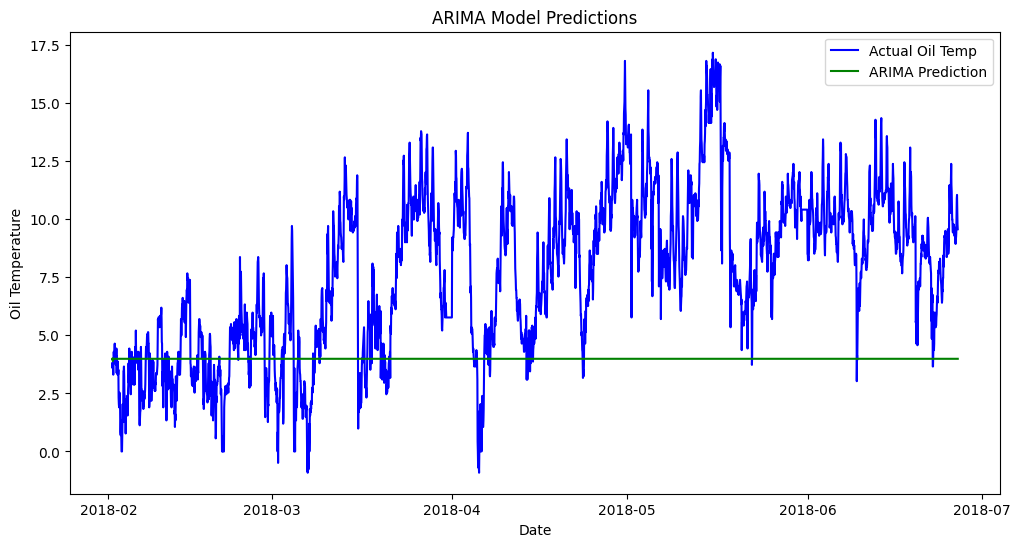

In [8]:
# ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Split the dataset into training and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Set 'date' as the index for time series modeling
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

# ARIMA model
model_arima = ARIMA(train['OT'], order=(5, 1, 0))  # You can fine-tune the (p,d,q) values
model_arima_fit = model_arima.fit()

# Make predictions
arima_predictions = model_arima_fit.forecast(steps=len(test))

# Calculate evaluation metrics
mse_arima = mean_squared_error(test['OT'], arima_predictions)
mae_arima = mean_absolute_error(test['OT'], arima_predictions)
r2_arima = r2_score(test['OT'], arima_predictions)
arima_rmse = np.sqrt(mse_arima)  # RMSE for better interpretability

# Print metrics
print(f"ARIMA Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_arima:.2f}")
print(f"Mean Absolute Error (MAE): {mae_arima:.2f}")
print(f"R-squared (R²): {r2_arima:.4f}")
print(f"Root Mean Squared Error (RMSE): {arima_rmse:.2f}")

# Plot ARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['OT'], color='blue', label='Actual Oil Temp')
plt.plot(test.index, arima_predictions, color='green', label='ARIMA Prediction')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()


Prophet Model

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6qxm9ulw/wix22vh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6qxm9ulw/weyyqsae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56476', 'data', 'file=/tmp/tmp6qxm9ulw/wix22vh8.json', 'init=/tmp/tmp6qxm9ulw/weyyqsae.json', 'output', 'file=/tmp/tmp6qxm9ulw/prophet_modelnh0l66op/prophet_model-20241010181047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version

Prophet Model Evaluation Metrics:
Mean Squared Error (MSE): 198.48
Mean Absolute Error (MAE): 12.66
R-squared (R²): -15.7143
Root Mean Squared Error (RMSE): 14.09


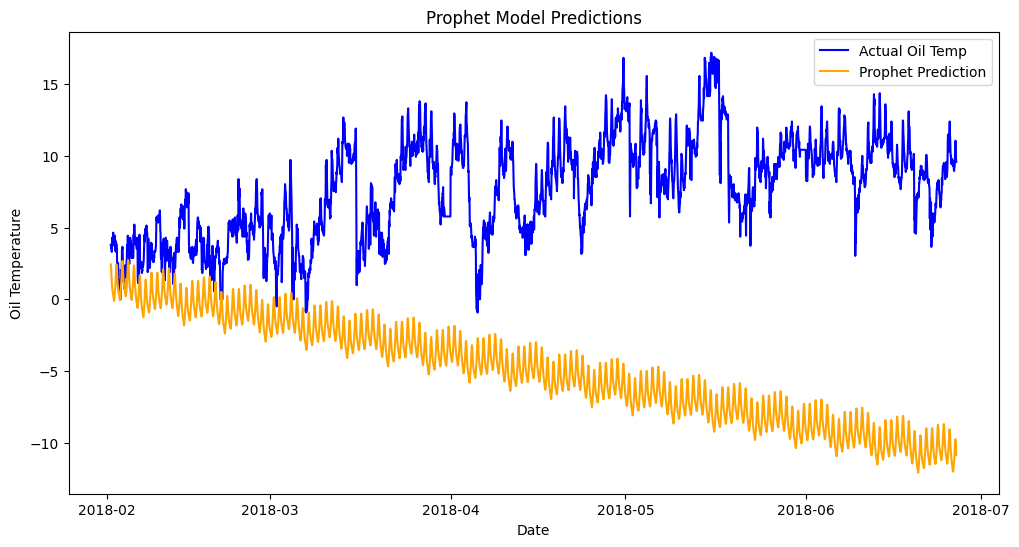

In [9]:
# Prophet Model
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Prepare data for Prophet model
df_prophet = df[['date', 'OT']].rename(columns={'date': 'ds', 'OT': 'y'})

# Split into train and test sets
train_prophet = df_prophet[:train_size]
test_prophet = df_prophet[train_size:]

# Create and train the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_prophet)

# Make predictions
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast = model_prophet.predict(future)

# Evaluate Prophet model
predicted_prophet = forecast['yhat'][-len(test):].values
mse_prophet = mean_squared_error(test['OT'], predicted_prophet)
mae_prophet = mean_absolute_error(test['OT'], predicted_prophet)
r2_prophet = r2_score(test['OT'], predicted_prophet)
prophet_rmse = np.sqrt(mse_prophet)  # RMSE for better interpretability

# Print metrics
print(f"Prophet Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_prophet:.2f}")
print(f"Mean Absolute Error (MAE): {mae_prophet:.2f}")
print(f"R-squared (R²): {r2_prophet:.4f}")
print(f"Root Mean Squared Error (RMSE): {prophet_rmse:.2f}")

# Plot Prophet predictions
plt.figure(figsize=(12, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], color='blue', label='Actual Oil Temp')
plt.plot(test_prophet['ds'], predicted_prophet, color='orange', label='Prophet Prediction')
plt.title('Prophet Model Predictions')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()


Enhancing model

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6qxm9ulw/aenj_u1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6qxm9ulw/f7ovyket.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29396', 'data', 'file=/tmp/tmp6qxm9ulw/aenj_u1n.json', 'init=/tmp/tmp6qxm9ulw/f7ovyket.json', 'output', 'file=/tmp/tmp6qxm9ulw/prophet_model9vtvylin/prophet_model-20241010181105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet Model Evaluation Metrics:
Mean Squared Error (MSE): 20.96
Mean Absolute Error (MAE): 3.72
R-squared (R²): -0.7651
Root Mean Squared Error (RMSE): 4.58


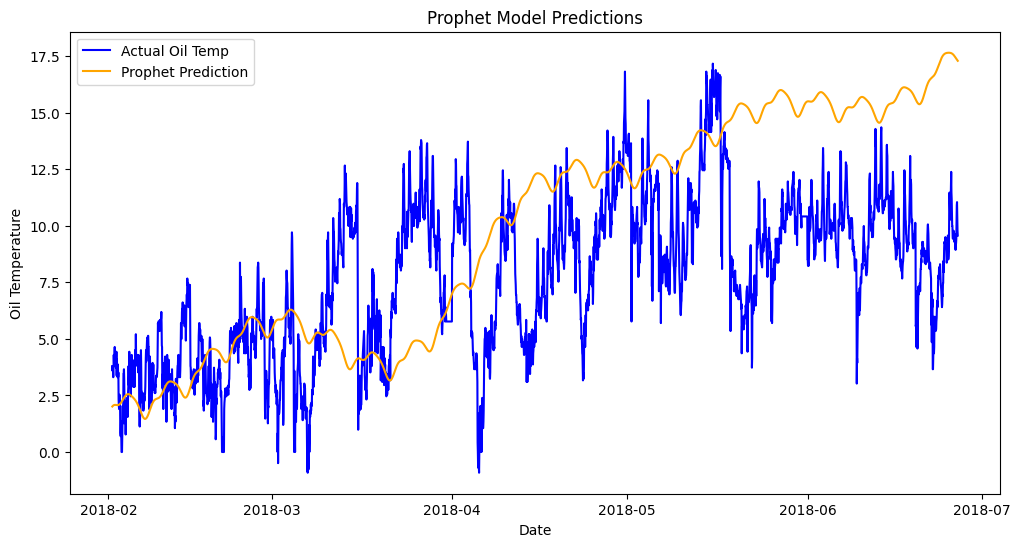

In [10]:
# Prophet Model
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Prepare data for Prophet model
df_prophet = df[['date', 'OT']].rename(columns={'date': 'ds', 'OT': 'y'})

# Split into train and test sets
train_prophet = df_prophet[:train_size]
test_prophet = df_prophet[train_size:]

# Create and train the Prophet model
model_prophet = Prophet(
    yearly_seasonality=True,   # Enable yearly seasonality if applicable
    weekly_seasonality=True,    # Enable weekly seasonality
    daily_seasonality=False      # Disable daily seasonality for hourly data
)

# If you have specific holidays that could affect the oil temperature, add them here
# Example of adding holidays (adjust the dates based on your data):
# holidays = pd.DataFrame({
#     'holiday': 'holiday_name',
#     'ds': pd.to_datetime(['YYYY-MM-DD', ...]),  # List of holiday dates
#     'lower_window': 0,
#     'upper_window': 1,
# })
# model_prophet = Prophet(holidays=holidays)

model_prophet.fit(train_prophet)

# Make predictions
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast = model_prophet.predict(future)

# Evaluate Prophet model
predicted_prophet = forecast['yhat'][-len(test):].values
mse_prophet = mean_squared_error(test_prophet['y'], predicted_prophet)
mae_prophet = mean_absolute_error(test_prophet['y'], predicted_prophet)
r2_prophet = r2_score(test_prophet['y'], predicted_prophet)
prophet_rmse = np.sqrt(mse_prophet)  # RMSE for better interpretability

# Print metrics
print(f"Prophet Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_prophet:.2f}")
print(f"Mean Absolute Error (MAE): {mae_prophet:.2f}")
print(f"R-squared (R²): {r2_prophet:.4f}")
print(f"Root Mean Squared Error (RMSE): {prophet_rmse:.2f}")

# Plot Prophet predictions
plt.figure(figsize=(12, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], color='blue', label='Actual Oil Temp')
plt.plot(test_prophet['ds'], predicted_prophet, color='orange', label='Prophet Prediction')
plt.title('Prophet Model Predictions')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()


LSTM Model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0069
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0017
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0012
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0011
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.5914e-04
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.1911e-04
Epoch 7/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 7.5325e-04
Epoch 8/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.3113e-04
Epoch 9/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 6.9109e-04
Epoch 10/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.0444e-04
Epoch 11/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5.8492e-04
Epoch 12/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.8159e-04
Epoch 13/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.9368e-04
Epoch 14/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5.7511e-04
Epoch 15/50
4

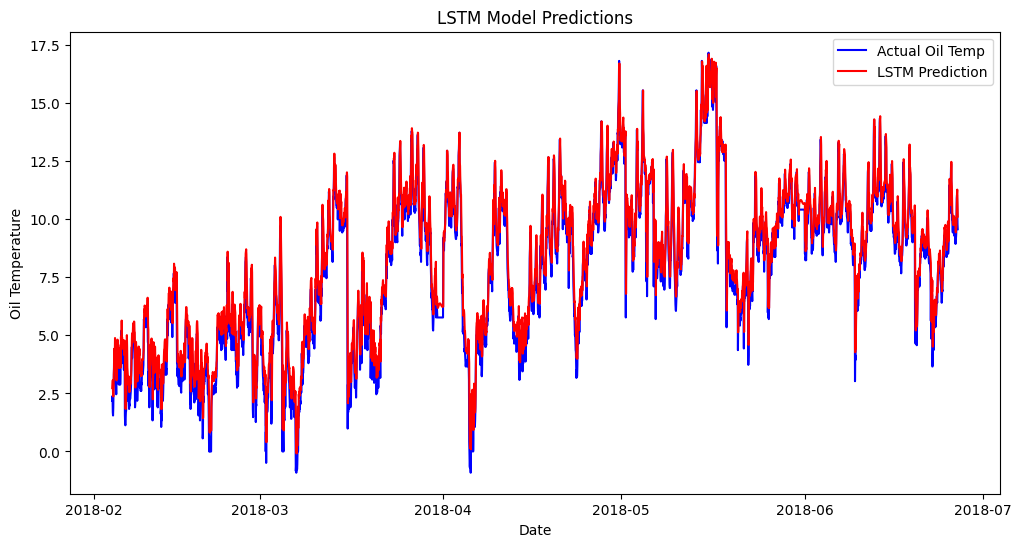

In [11]:
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Normalize the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['OT']])
test_scaled = scaler.transform(test[['OT']])

# Prepare data for LSTM
X_train, y_train = [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# LSTM model architecture with Dropout and more units
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))  # Dropout for regularization
model_lstm.add(LSTM(units=100, return_sequences=False))  # Add another LSTM layer
model_lstm.add(Dropout(0.2))  # Dropout for regularization
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stopping])

# Prepare test data for predictions
X_test = []
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions
predicted_lstm = model_lstm.predict(X_test)
predicted_lstm = scaler.inverse_transform(predicted_lstm)

# Evaluate LSTM model
mse_lstm = mean_squared_error(test['OT'][60:], predicted_lstm)
mae_lstm = mean_absolute_error(test['OT'][60:], predicted_lstm)
r2_lstm = r2_score(test['OT'][60:], predicted_lstm)
lstm_rmse = np.sqrt(mse_lstm)

# Print metrics
print(f"LSTM Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_lstm:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lstm:.2f}")
print(f"R-squared (R²): {r2_lstm:.4f}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse:.2f}")

# Plot LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[60:], test['OT'][60:], color='blue', label='Actual Oil Temp')
plt.plot(test.index[60:], predicted_lstm, color='red', label='LSTM Prediction')
plt.title('LSTM Model Predictions')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()


CHRONOS Model

In [12]:
!pip install chronos


In [14]:
print(df.columns)

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


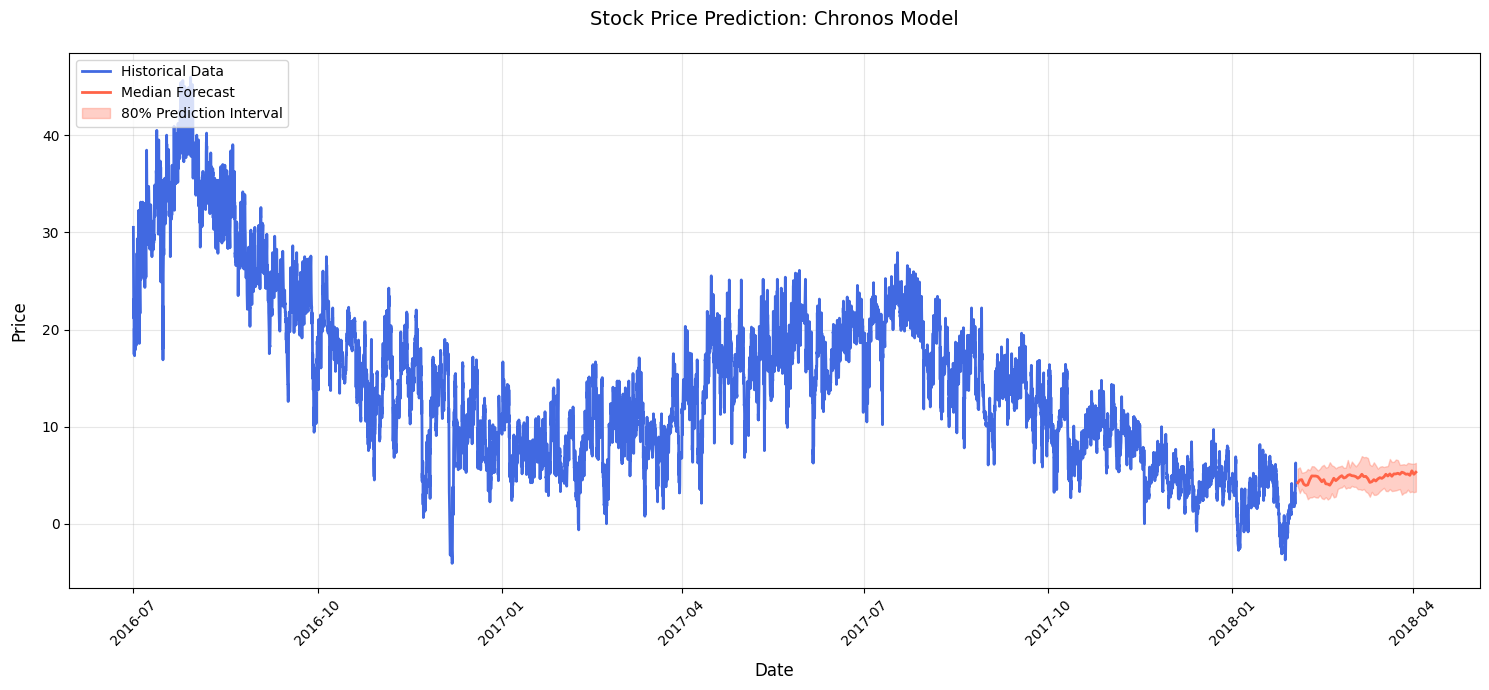


Predictions for the next 60 days:
               Date  Median_Prediction  Lower_Bound  Upper_Bound
2018-02-02 15:00:00           4.219219     3.840448     5.674370
2018-02-03 15:00:00           4.506893     3.157222     5.803823
2018-02-04 15:00:00           4.542852     3.603117     5.252448
2018-02-05 15:00:00           4.075382     3.214757     5.295599
2018-02-06 15:00:00           3.943531     3.097290     5.374709
2018-02-07 15:00:00           4.003463     2.519545     5.640808
2018-02-08 15:00:00           4.542852     2.706533     5.511355
2018-02-09 15:00:00           4.926418     2.713725     5.933277
2018-02-10 15:00:00           4.914431     2.814411     5.911701
2018-02-11 15:00:00           4.914431     2.713725     5.712726
2018-02-12 15:00:00           4.854499     2.692149     5.489779
2018-02-13 15:00:00           4.614771     2.951056     5.640808
2018-02-14 15:00:00           4.327097     2.620231     5.940469
2018-02-15 15:00:00           4.542852     2.533929    

In [18]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from chronos import ChronosPipeline


# Split the data into train and test sets (80:20 split)
train_size = int(len(df) * 0.8)
train_chronos = df.iloc[:train_size]
test_chronos = df.iloc[train_size:]

# Initialize the Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16
)

# Prepare the context (historical data)
context = torch.tensor(train_chronos['OT'].values, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Set prediction parameters
prediction_length = 60  # Increase prediction length to 60 days

# Generate predictions
forecast = pipeline.predict(context, prediction_length, limit_prediction_length=False)  # Shape: [num_series, num_samples, prediction_length]

# Calculate quantiles for the prediction intervals
low, median, high = np.quantile(forecast[0].cpu().numpy(), [0.1, 0.5, 0.9], axis=0)

# Create future dates for plotting
future_dates = pd.date_range(start=train_chronos.index[-1] + pd.Timedelta(days=1), periods=prediction_length)

# Plotting
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(train_chronos.index, train_chronos['OT'], color='royalblue', label='Historical Data', linewidth=2)

# Plot predictions
plt.plot(future_dates, median, color='tomato', label='Median Forecast', linewidth=2)

# Plot confidence intervals
plt.fill_between(future_dates, low, high, color='tomato', alpha=0.3, label='80% Prediction Interval')

plt.title('Stock Price Prediction: Chronos Model', pad=20, size=14)
plt.xlabel('Date', labelpad=10, size=12)
plt.ylabel('Price', labelpad=10, size=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print predictions
print("\nPredictions for the next", prediction_length, "days:")
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Median_Prediction': median,
    'Lower_Bound': low,
    'Upper_Bound': high
})
print(predictions_df.to_string(index=False))

# Calculate and print additional metrics
prediction_range = high - low
average_uncertainty = np.mean(prediction_range)
print(f"\nAverage prediction uncertainty: {average_uncertainty:.2f}")
